# Import and create the context of the application

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                        LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel

spark = SparkSession.builder.appName('Network_Flow_Classification').getOrCreate()

# Data Preprocessing
Load the NF-UQ-NIDS-v2 dataset

In [2]:
base_df = spark.read.csv("NF-UQ-NIDS-v2.csv", header=True, inferSchema=True)
base_df.show(5)

+---------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+-------------+
|  IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHOR

Drop the "Attack" (the type of attack) and "Dataset" (the dataset from which the data comes from) columns beacuse they are not needed

In [3]:
df = base_df.drop("Attack", "Dataset")
df.printSchema()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO

Drop the null values from the dataset

In [21]:
df.count()

75987976

In [9]:
df2 = df.na.drop()
df2.count()

75987976

Transformation of categorical variables

In [5]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCols=["IPV4_SRC_ADDR", "IPV4_DST_ADDR"], outputCols=["IPV4_SRC_ADDR_Index", "IPV4_DST_ADDR_Index"])
si_fit = si.fit(df)

df_indexed = si_fit.transform(df)

In [6]:
df = df_indexed.drop("IPV4_SRC_ADDR", "IPV4_DST_ADDR")
df.printSchema()

root
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO_DST_SECOND_BYTES: double (nullable = true)
 |-- DST_TO_SRC_SECOND_BYTES: double (nullable

# Correlation Matrix
Compute the Correlation Matrix

In [7]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

corr = Correlation.corr(df_vector, vector_col)

matrix = corr.collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,IPV4_SRC_ADDR_Index,IPV4_DST_ADDR_Index
L4_SRC_PORT,1.00,-0.08,-0.01,-0.23,-0.00,0.00,0.00,0.00,0.18,0.17,0.14,-0.34,-0.26,-0.02,-0.03,-0.03,0.17,-0.11,0.36,0.17,nan,-0.00,-0.01,-0.01,-0.02,-0.02,0.00,0.01,0.01,-0.01,0.00,-0.00,0.00,0.14,0.17,-0.06,-0.06,0.25,0.04,-0.00,-0.02,-0.30,0.00,0.05
L4_DST_PORT,-0.08,1.00,-0.21,-0.18,0.00,-0.00,0.00,0.00,-0.01,-0.03,0.07,-0.26,-0.18,0.05,-0.28,-0.28,-0.00,-0.10,0.03,-0.00,nan,-0.00,0.00,0.01,0.03,0.03,0.03,0.07,-0.00,-0.01,0.00,0.00,0.00,0.05,-0.03,-0.05,-0.05,-0.10,-0.01,0.01,-0.02,-0.11,-0.01,-0.02
PROTOCOL,-0.01,-0.21,1.00,0.62,-0.00,0.00,-0.01,-0.01,-0.31,-0.29,-0.40,0.12,0.04,-0.10,-0.08,-0.08,-0.35,-0.30,0.02,-0.35,-0.00,0.00,-0.01,-0.03,-0.03,-0.04,-0.11,-0.08,0.01,-0.03,-0.01,-0.00,-0.01,-0.34,-0.36,-0.24,-0.24,0.41,0.07,0.00,-0.06,0.05,-0.06,-0.08
L7_PROTO,-0.23,-0.18,0.62,1.00,-0.00,-0.01,-0.01,-0.01,-0.19,-0.17,-0.27,0.50,0.23,-0.04,0.18,0.17,-0.28,-0.45,-0.48,-0.28,-0.00,-0.00,-0.01,-0.02,-0.02,-0.03,-0.09,-0.05,-0.01,-0.03,-0.01,-0.00,-0.01,-0.20,-0.22,-0.18,-0.18,-0.22,-0.04,-0.00,-0.05,0.38,-0.02,-0.02
IN_BYTES,-0.00,0.00,-0.00,-0.00,1.00,0.44,0.09,0.17,0.00,0.00,0.00,0.00,0.17,0.01,0.01,0.01,0.03,0.01,0.01,0.03,nan,0.00,0.12,0.08,0.01,0.02,0.15,0.01,0.13,0.05,0.34,0.58,0.32,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00
IN_PKTS,0.00,-0.00,0.00,-0.01,0.44,1.00,0.11,0.12,0.00,0.00,0.00,0.01,0.52,0.01,0.02,0.02,0.01,-0.00,-0.00,0.01,nan,0.00,0.02,0.03,0.05,0.05,0.05,0.02,0.37,0.03,0.09,0.12,0.14,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
OUT_BYTES,0.00,0.00,-0.01,-0.01,0.09,0.11,1.00,0.83,0.01,0.01,0.01,0.00,-0.01,0.01,0.01,0.01,0.04,-0.00,0.01,0.04,nan,0.00,0.00,0.01,0.15,0.15,0.05,0.19,0.04,0.02,0.14,0.17,0.94,0.02,0.01,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.02,-0.00,0.02
OUT_PKTS,0.00,0.00,-0.01,-0.01,0.17,0.12,0.83,1.00,0.02,0.02,0.02,-0.00,-0.01,0.03,0.02,0.02,0.05,-0.01,0.02,0.05,-0.00,0.00,0.04,0.03,0.14,0.14,0.07,0.17,0.08,0.09,0.22,0.22,0.81,0.03,0.02,0.02,0.02,-0.01,-0.00,-0.00,0.00,-0.02,-0.00,0.02
TCP_FLAGS,0.18,-0.01,-0.31,-0.19,0.00,0.00,0.01,0.02,1.00,1.00,0.72,-0.20,-0.22,0.02,0.48,0.48,0.62,-0.18,0.25,0.62,-0.00,-0.00,0.00,0.02,0.00,0.01,0.15,0.11,-0.00,0.02,0.02,0.00,0.01,0.40,0.66,0.07,0.07,-0.14,-0.02,-0.00,-0.00,-0.28,-0.01,0.18
CLIENT_TCP_FLAGS,0.17,-0.03,-0.29,-0.17,0.00,0.00,0.01,0.02,1.00,1.00,0.70,-0.19,-0.22,0.02,0.50,0.50,0.63,-0.17,0.23,0.63,-0.00,-0.00,0.00,0.02,0.00,0.01,0.15,0.11,-0.00,0.02,0.02,0.00,0.01,0.40,0.67,0.07,0.07,-0.13,-0.02,-0.00,0.00,-0.28,-0.01,0.18


Select the most relevant columns fom the dataset based on the correlation matrix

In [4]:
final_df = df.select(["L4_SRC_PORT", "L7_PROTO", "SERVER_TCP_FLAGS", "FLOW_DURATION_MILLISECONDS", "DURATION_IN", "MIN_IP_PKT_LEN", "DNS_QUERY_ID", "Label"])
final_df.show(5)

+-----------+--------+----------------+--------------------------+-----------+--------------+------------+-----+
|L4_SRC_PORT|L7_PROTO|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|MIN_IP_PKT_LEN|DNS_QUERY_ID|Label|
+-----------+--------+----------------+--------------------------+-----------+--------------+------------+-----+
|      65389|     7.0|               0|                   4293092|       1875|             0|           0|    1|
|      11154|     7.0|              20|                   4294499|        453|            40|           0|    1|
|      42062|     0.0|              20|                         0|          0|            40|           0|    0|
|      46849|     0.0|              20|                         0|          0|            40|           0|    0|
|      50360|     0.0|              20|                         0|          0|            40|           0|    0|
+-----------+--------+----------------+--------------------------+-----------+--------------+---

Save the final data set

In [5]:
final_df.repartition(1).write.option("header", True).csv("NFC.csv")

# Training the Machine Learnig Algorithms
Load the dataset

In [2]:
df = spark.read.csv("NFCDF.csv", header=True, inferSchema=True)
df.show(5)

+-----------+--------+----------------+--------------------------+-----------+--------------+------------+-----+
|L4_SRC_PORT|L7_PROTO|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|MIN_IP_PKT_LEN|DNS_QUERY_ID|Label|
+-----------+--------+----------------+--------------------------+-----------+--------------+------------+-----+
|      65389|     7.0|               0|                   4293092|       1875|             0|           0|    1|
|      11154|     7.0|              20|                   4294499|        453|            40|           0|    1|
|      42062|     0.0|              20|                         0|          0|            40|           0|    0|
|      46849|     0.0|              20|                         0|          0|            40|           0|    0|
|      50360|     0.0|              20|                         0|          0|            40|           0|    0|
+-----------+--------+----------------+--------------------------+-----------+--------------+---

Assemble features into a vector

In [3]:
df = df.limit(75_000_000)

input_cols = df.columns
input_cols.remove("Label")

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "Label"])

Split the data into training and testing

In [4]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed = 16)

In [5]:
train_data.describe().show()
test_data.describe().show()

+-------+-------------------+
|summary|              Label|
+-------+-------------------+
|  count|           52498911|
|   mean| 0.6687790152447162|
| stddev|0.47065236452441445|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+------------------+
|summary|             Label|
+-------+------------------+
|  count|          22501089|
|   mean| 0.668971399562039|
| stddev|0.4705833358415567|
|    min|                 0|
|    max|                 1|
+-------+------------------+



## Logistic Regression
Train the Logistic Regression algorithm

In [8]:
lr = LogisticRegression(labelCol='Label')

startTime = time()

lr_model = lr.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

825.842978477478 seconds


Save the model and load it

In [16]:
lr_model.save("LR_Model")

In [6]:
lr_model = LogisticRegressionModel.load("LR_Model")

Feature Importance

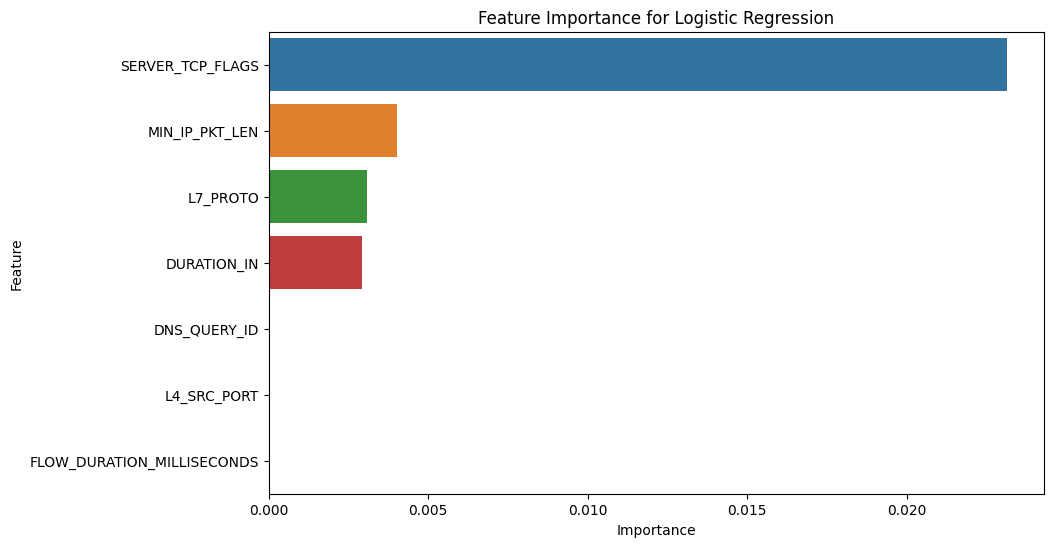

In [19]:
coefficients = lr_model.coefficients.toArray()
feature_names = ['L4_SRC_PORT', 'L7_PROTO', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 
                 'DURATION_IN', 'MIN_IP_PKT_LEN', 'DNS_QUERY_ID']

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Compute the metrics

In [7]:
predictions = lr_model.transform(test_data)

In [11]:
predictions.show()

+---------+-----+--------------------+--------------------+----------+
| features|Label|       rawPrediction|         probability|prediction|
+---------+-----+--------------------+--------------------+----------+
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[],[])|    0|[-0.3828094434474...|[0.40544947257115...|         1|
|(7,[]

In [10]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))

In [13]:
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

In [14]:
tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

In [15]:
print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 12392455
 False Positives: 2660130
 False Negatives: 666388
 True Negatives: 6782116


In [16]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [17]:
print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.8521619109190671
 Precision: 0.8232775300720773
 Recall: 0.9489703643730153
 F1-Score: 0.8816667015279337


## Random Forest
Train the Random Forest algorithm

In [9]:
rf = RandomForestClassifier(labelCol='Label')

startTime = time()

rf_model = rf.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

1967.396730184555 seconds


Save the model and load it

In [18]:
rf_model.save("RF_Model")

In [20]:
rf_model = RandomForestClassificationModel.load("RF_Model")

Feature Importance

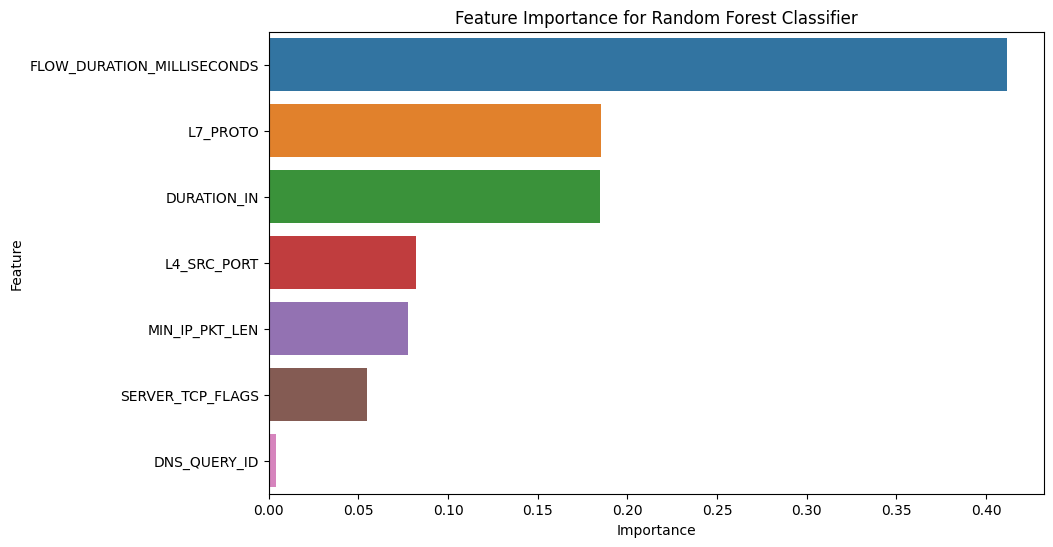

In [23]:
importances = rf_model.featureImportances.toArray()
feature_names = ['L4_SRC_PORT', 'L7_PROTO', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 
                 'DURATION_IN', 'MIN_IP_PKT_LEN', 'DNS_QUERY_ID']

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Compute the metrics

In [26]:
predictions = rf_model.transform(test_data)

In [27]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))

In [28]:
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

In [29]:
tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

In [30]:
print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 13436239
 False Positives: 1616346
 False Negatives: 505692
 True Negatives: 6942812


In [31]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [32]:
print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9056917645185973
 Precision: 0.8926200383522166
 Recall: 0.9637286972658236
 F1-Score: 0.9268124358413157


## Gradient-Boosted Tree
Train the Gradient-Boosted Tree algorithm

In [10]:
gbt = GBTClassifier(labelCol='Label')

startTime = time()

gbt_model = gbt.fit(train_data)

endTime = time()
print(f"{endTime - startTime} seconds")

6937.711089849472 seconds


Save the model and load it

In [9]:
gbt_model.save("GBT_Model")

In [24]:
gbt_model = GBTClassificationModel.load("GBT_Model")

Feature Importance

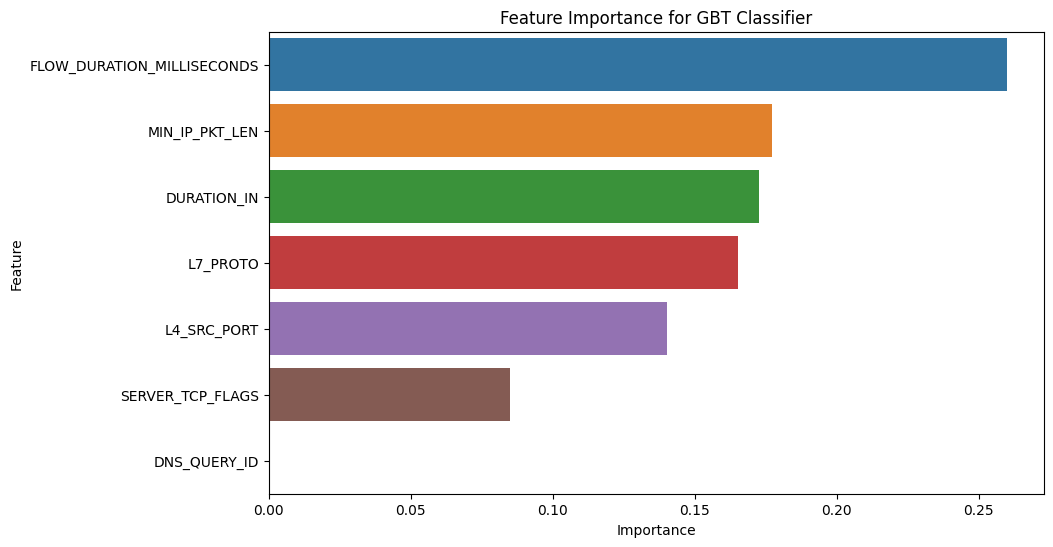

In [25]:
importances = gbt_model.featureImportances.toArray()
feature_names = ['L4_SRC_PORT', 'L7_PROTO', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 
                 'DURATION_IN', 'MIN_IP_PKT_LEN', 'DNS_QUERY_ID'] 

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for GBT Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Compute the metrics

In [34]:
predictions = gbt_model.transform(test_data)

In [35]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))

In [36]:
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Label"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Label"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Label"] == 0), 2) \
                                                .otherwise(3))

In [37]:
tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

In [38]:
print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 14012793
 False Positives: 1039792
 False Negatives: 554911
 True Negatives: 6893593


In [39]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [40]:
print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9291277413284308
 Precision: 0.9309226953377111
 Recall: 0.9619081359698137
 F1-Score: 0.9461618014598034
